<span style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">An Exception was encountered at '<a href="#papermill-error-cell">In [13]</a>'.</span>

In [1]:
import pandas as pd
import numpy as np

from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
df_rfm = pd.read_csv('./data/customer_features_cleaned.csv')

In [2]:
df_rfm.head()

,Invoice,StockCode,Description,Quantity,InvoiceDate,Price,Customer ID,Country,TotalPrice,Year,Month,Day,Hour,Weekday,DateOnly,Revenue
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,6.95,13085.0,United Kingdom,42.075,2009,12,1,7,Tuesday,2009-12-01,83.4
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,42.075,2009,12,1,7,Tuesday,2009-12-01,81.0
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,6.75,13085.0,United Kingdom,42.075,2009,12,1,7,Tuesday,2009-12-01,81.0
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",27,2009-12-01 07:45:00,2.10,13085.0,United Kingdom,42.075,2009,12,1,7,Tuesday,2009-12-01,56.7
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,1.25,13085.0,United Kingdom,30.000,2009,12,1,7,Tuesday,2009-12-01,30.0


Chuyển đổi InvoiceDate sang kiểu datetime.date để tính toán độ mới (Recency).

max_date dùng để tính Recency: khoảng cách giữa lần mua cuối của khách và ngày cuối cùng trong dữ liệu.

In [3]:
df_rfm['InvoiceDate_notime'] = pd.to_datetime(df_rfm['InvoiceDate']).dt.date
max_date = max(df_rfm["InvoiceDate_notime"])
max_date

datetime.date(2011, 12, 9)

# 1. RFM

## Tính toán các giá trị RFM theo từng khách hàng

In [4]:
rfm = df_rfm.groupby("Customer ID").agg(monetary = ("TotalPrice", "sum"),
                                    frequency = ("Invoice", lambda x: x.nunique()),
                                    recency = ("InvoiceDate_notime", lambda y: max_date - y.max()))
rfm["recency"] = rfm["recency"].dt.days.astype("int") + 1
print(rfm.info())
print("")
rfm.head(3)

<class 'pandas.core.frame.DataFrame'>
Index: 5881 entries, 12346.0 to 18287.0
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   monetary   5881 non-null   float64
 1   frequency  5881 non-null   int64  
 2   recency    5881 non-null   int64  
dtypes: float64(1), int64(2)
memory usage: 183.8 KB
None



,monetary,frequency,recency
Customer ID,,,
12346.0,412.01,12,326
12347.0,4375.20,8,3
12348.0,1328.70,5,76


In [5]:
rfm.describe()

,monetary,frequency,recency
count,5881.000000,5881.000000,5881.000000
mean,1929.092091,6.287196,201.992858
std,5315.536459,13.012879,209.489651
min,0.000000,1.000000,1.000000
25%,301.900000,1.000000,26.000000
50%,746.360000,3.000000,96.000000
75%,1890.595000,7.000000,380.000000
max,229725.560000,398.000000,739.000000


# Phân nhóm thành các Tứ phân vị (Quartiles) cho từng chỉ số R, F, M

In [6]:
rfm['Recency_Quartile'] = pd.qcut(rfm['recency'], 
                                  q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])
rfm['Frequency_Quartile'] = pd.qcut(rfm['frequency'], labels=['Q1', 'Q2', 'Q3'], 
                                    q=3) # there's only 3 segments as per below
rfm['MonetaryValue_Quartile'] = pd.qcut(rfm['monetary'], 
                                        q=4, labels=['Q1', 'Q2', 'Q3', 'Q4'])

rfm.head(3)

,monetary,frequency,recency,Recency_Quartile,Frequency_Quartile,MonetaryValue_Quartile
Customer ID,,,,,,
12346.0,412.01,12,326,Q3,Q3,Q2
12347.0,4375.20,8,3,Q1,Q3,Q4
12348.0,1328.70,5,76,Q2,Q2,Q3


In [7]:
rfm['Frequency_Quartile'].unique()


['Q3', 'Q2', 'Q1']
Categories (3, object): ['Q1' < 'Q2' < 'Q3']

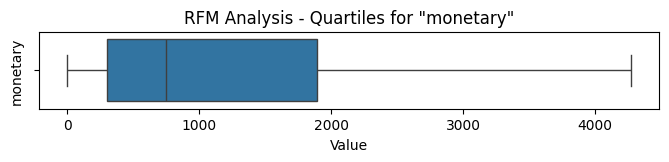

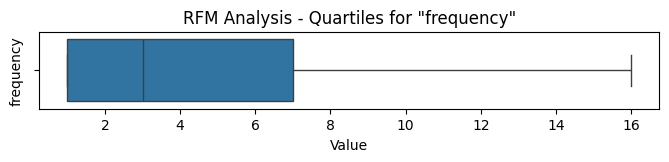

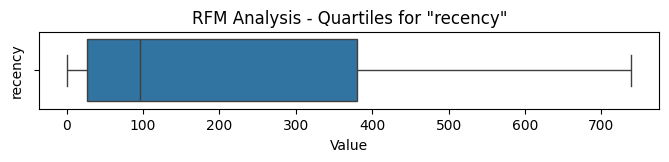

In [8]:
for i in rfm.columns[:3]:
    plt.figure(figsize=(8, 1))
    sns.boxplot(data=rfm[i], showfliers=False, orient='h')
    plt.title(f'RFM Analysis - Quartiles for "{i}"')
    plt.xlabel('Value')
    plt.ylabel(i)
    plt.show()

| Chỉ số    | Ý nghĩa trực quan                                            | Hành động gợi ý                            |
| --------- | ------------------------------------------------------------ | ------------------------------------------ |
| Monetary  | Nhiều khách chi ít, vài người chi cực nhiều → phân phối lệch | Xem xét tập trung chăm sóc top spender     |
| Frequency | Đa số mua ít lần                                             | Khuyến mãi giữ chân, upsell                |
| Recency   | Phần lớn khách hàng lâu rồi chưa quay lại                    | Tái kích hoạt (email, SMS, ưu đãi trở lại) |


# 2. Phân nhóm khách hàng

In [9]:
# Gộp các điểm để tạo mã phân nhóm RFM
rfm['RFM_Score'] = rfm['Recency_Quartile'].astype(str) + \
                   rfm['Frequency_Quartile'].astype(str) + \
                   rfm['MonetaryValue_Quartile'].astype(str)

rfm[['recency', 'frequency', 'monetary', 'Recency_Quartile', 
     'Frequency_Quartile', 'MonetaryValue_Quartile', 'RFM_Score']].head()


,recency,frequency,monetary,Recency_Quartile,Frequency_Quartile,MonetaryValue_Quartile,RFM_Score
Customer ID,,,,,,,
12346.0,326,12,412.01,Q3,Q3,Q2,Q3Q3Q2
12347.0,3,8,4375.20,Q1,Q3,Q4,Q1Q3Q4
12348.0,76,5,1328.70,Q2,Q2,Q3,Q2Q2Q3
12349.0,19,4,3517.19,Q1,Q2,Q4,Q1Q2Q4
12350.0,311,1,334.40,Q3,Q1,Q2,Q3Q1Q2


In [10]:
def segment_customer(row):
    if row['RFM_Score'] in ['Q1Q3Q4', 'Q1Q2Q4']:  # Recency tốt, chi nhiều, mua nhiều
        return 'Champions'
    elif row['Recency_Quartile'] == 'Q1':
        return 'Recent Customers'
    elif row['Frequency_Quartile'] == 'Q3':
        return 'Loyal Customers'
    elif row['MonetaryValue_Quartile'] == 'Q4':
        return 'Big Spenders'
    elif row['Recency_Quartile'] == 'Q4':
        return 'At Risk'
    else:
        return 'Others'

rfm['Customer_Segment'] = rfm.apply(segment_customer, axis=1)

rfm['Customer_Segment'].value_counts()


Customer_Segment
Others              1946
At Risk             1380
Loyal Customers      922
Recent Customers     756
Champions            732
Big Spenders         145
Name: count, dtype: int64

| Nhóm khách hàng      | Ý nghĩa hành vi                            | Gợi ý hành động marketing                       |
| -------------------- | ------------------------------------------ | ----------------------------------------------- |
| **Champions**        | Gần đây mua, mua nhiều, chi nhiều          | Giữ chân, tặng voucher VIP                      |
| **Loyal Customers**  | Mua lặp lại nhiều                          | Chương trình khách hàng thân thiết              |
| **Big Spenders**     | Chi nhiều nhưng không nhất thiết mua nhiều | Ưu đãi độc quyền theo giá trị hóa đơn           |
| **Recent Customers** | Mới mua hàng gần đây                       | Gửi email cảm ơn, mời tham gia khảo sát         |
| **At Risk**          | Lâu không quay lại                         | Gửi ưu đãi khuyến mãi để kích hoạt lại          |
| **Others**           | Hành vi không rõ ràng                      | Quan sát thêm hoặc đẩy sang chiến dịch khảo sát |


In [11]:
df_c = pd.read_csv('./data/processed_data.csv')

# Đảm bảo cột 'Invoice' là kiểu chuỗi để kiểm tra ký tự 'C'
df_c['Invoice'] = df_c['Invoice'].astype(str)

# Tạo cột is_cancelled: 1 nếu Invoice chứa 'C', ngược lại 0
df_c['is_cancelled'] = df_c['Invoice'].str.startswith('C').astype(int)
df_c.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 779495 entries, 0 to 779494
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Invoice       779495 non-null  object 
 1   StockCode     779495 non-null  object 
 2   Description   779495 non-null  object 
 3   Quantity      779495 non-null  int64  
 4   InvoiceDate   779495 non-null  object 
 5   Price         779495 non-null  float64
 6   Customer ID   779495 non-null  float64
 7   Country       779495 non-null  object 
 8   TotalPrice    779495 non-null  float64
 9   is_cancelled  779495 non-null  int64  
dtypes: float64(3), int64(2), object(5)
memory usage: 59.5+ MB


In [12]:
df_c = df_c.drop(columns=['Invoice', 'StockCode', 'Description', 'Quantity', 'TotalPrice','Customer ID'])
df_c.head()

,InvoiceDate,Price,Country,is_cancelled
0,2009-12-01 07:45:00,6.95,United Kingdom,0
1,2009-12-01 07:45:00,6.75,United Kingdom,0
2,2009-12-01 07:45:00,6.75,United Kingdom,0
3,2009-12-01 07:45:00,2.10,United Kingdom,0
4,2009-12-01 07:45:00,1.25,United Kingdom,0


<span id="papermill-error-cell" style="color:red; font-family:Helvetica Neue, Helvetica, Arial, sans-serif; font-size:2em;">Execution using papermill encountered an exception here and stopped:</span>

In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

# === 1. Tiền xử lý ===
df = df_c.copy()

# Chuyển InvoiceDate thành datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Trích xuất các đặc trưng thời gian
df['InvoiceHour'] = df['InvoiceDate'].dt.hour
df['InvoiceWeekday'] = df['InvoiceDate'].dt.weekday  # 0 = Monday, 6 = Sunday

# Mã hóa quốc gia bằng one-hot encoding
df = pd.get_dummies(df, columns=['Country'], drop_first=True)

# === 2. Tạo tập đặc trưng và nhãn ===
features = ['Price', 'InvoiceHour', 'InvoiceWeekday'] + \
           [col for col in df.columns if col.startswith('Country_')]

X = df[features]
y = df['is_cancelled']

# === 3. Tách dữ liệu ===
X_train, X_test, y_train, y_test = train_test_split(
    X, y, stratify=y, random_state=42, test_size=0.2
)

# Chuẩn hóa dữ liệu
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# === 4. Huấn luyện mô hình ===
model = RandomForestClassifier(random_state=42)
model.fit(X_train_scaled, y_train)

# === 5. Dự đoán & Đánh giá ===
y_pred = model.predict(X_test_scaled)
y_proba = model.predict_proba(X_test_scaled)[:, 1]  # Xác suất bị huỷ

# Kết quả
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("\nClassification Report:\n", classification_report(y_test, y_pred, digits=4))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


IndexError: index 1 is out of bounds for axis 1 with size 1